# Question 2
## Part a.
### EIRNN Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np
import math
import logging
import neurogym as ngym
import matplotlib.pyplot as plt
import torch.optim as optim
import neurogym as ngym
import logging

/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal
        mask_no_diag = np.ones((self.hidden_size,self.hidden_size)) -  np.diag(np.ones((self.hidden_size)))
        E_I_unit_list = np.concatenate((np.ones((self.e_size,1)),-1*np.ones((self.i_size,1)))).T
        mask = mask_no_diag*E_I_unit_list
        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

In [4]:

class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden
class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

In [5]:
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'PerceptualDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)


/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Step 200, Loss 0.5659
Step 400, Loss 0.3255
Step 600, Loss 0.2273
Step 800, Loss 0.1728
Step 1000, Loss 0.1376
Step 1200, Loss 0.1196
Step 1400, Loss 0.1036
Step 1600, Loss 0.0940
Step 1800, Loss 0.0894
Step 2000, Loss 0.0816
Step 2200, Loss 0.0774
Step 2400, Loss 0.0755
Step 2600, Loss 0.0725
Step 2800, Loss 0.0719
Step 3000, Loss 0.0690
Step 3200, Loss 0.0673
Step 3400, Loss 0.0669
Step 3600, Loss 0.0662
Step 3800, Loss 0.0656
Step 4000, Loss 0.0647
Step 4200, Loss 0.0632
Step 4400, Loss 0.0655
Step 4600, Loss 0.0620
Step 4800, Loss 0.0622
Step 5000, Loss 0.0641


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


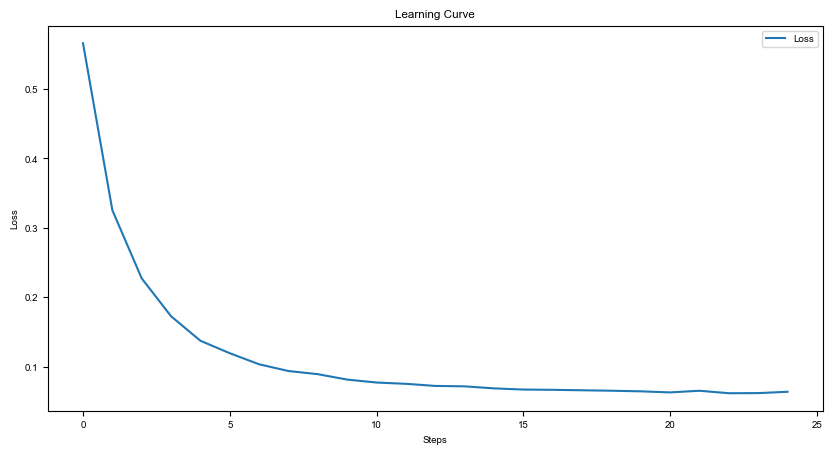

In [ ]:
# Training Loop (code from lab notebooks)
# Instantiate the network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Evaluate the network (code from lab notebook)
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Average performance 0.812


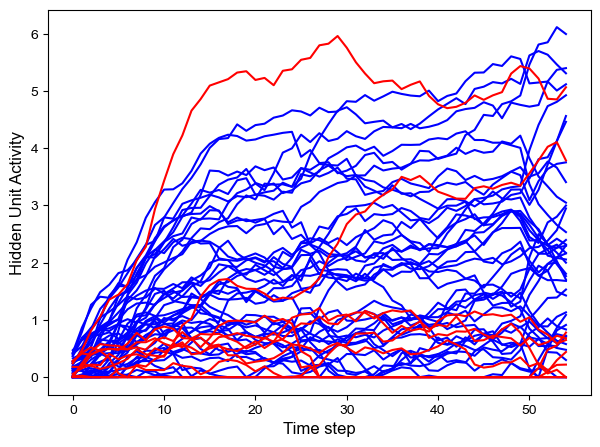

In [ ]:
# Plot neural activity from sample trials (code from lab notebooks)
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

e_size = net.rnn.e_size
trial = 0

plt.figure(figsize=(7, 5))
_ = plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step', fontsize=12)
plt.ylabel('Hidden Unit Activity', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [ ]:
# Compute selectivity for each neuron (code from lab notebooks)

# Here for each neuron we compute its stimulus period selectivity
mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:])+e_size))

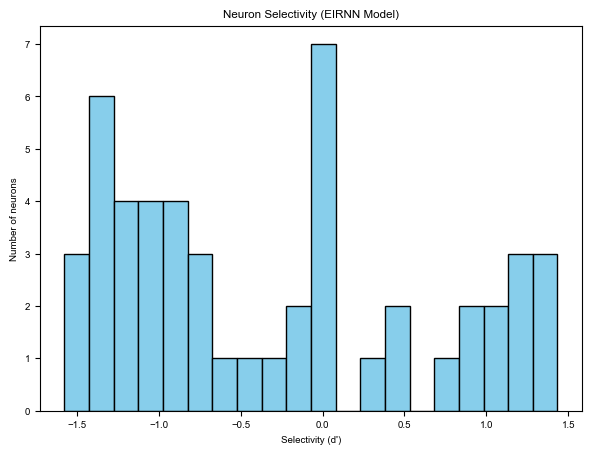

Text(0.5, 1.0, 'Network connectivity')

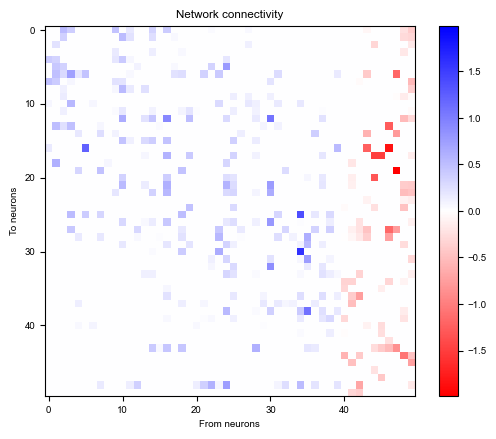

In [10]:
# @title Plot network connectivity sorted by stimulus selectivity

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Plot selectivity distribution
plt.figure(figsize=(7, 5))
plt.hist(selectivity, bins=20, color="skyblue", edgecolor="black")
plt.title("Neuron Selectivity (EIRNN Model)")
plt.xlabel("Selectivity (d')")
plt.ylabel("Number of neurons")
plt.show()

W = net.rnn.h2h.effective_weight().detach().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')

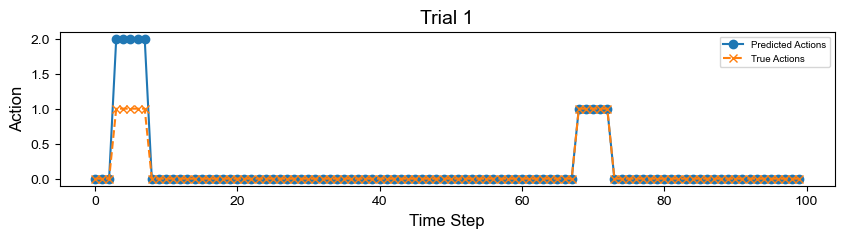

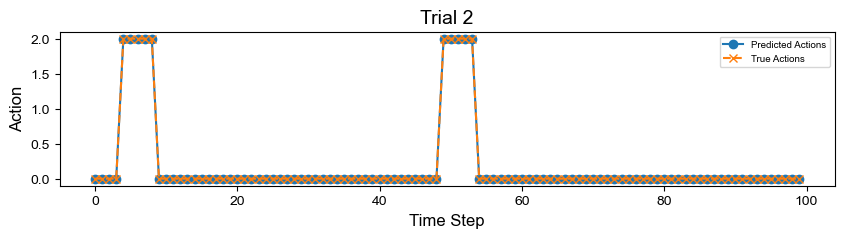

In [11]:
# Ensure compatibility with dataset output format
with torch.no_grad():
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels).type(torch.long)
    preds, _ = net(inputs)
    predicted_actions = preds.argmax(dim=-1).cpu().numpy()
    labels = labels.numpy()

# Plot predictions and true actions for the first three trials
for trial in range(2):
    plt.figure(figsize=(10, 2))
    plt.title(f"Trial {trial + 1}", fontsize=14)
    plt.plot(predicted_actions[:, trial], label='Predicted Actions', marker='o')
    plt.plot(labels[:, trial], label='True Actions', linestyle='--', marker='x')
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Action", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend()
    plt.show()